In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, log_loss
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import re
from sqlalchemy import create_engine
from imblearn.under_sampling import RandomUnderSampler
import random

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Database connection setup
db_config = {
    'host': 'localhost',
    'database': 'postgres',
    'user': 'postgres',
    'password': 'kaviyam123',
    'port': '5432'
}

connection_string = f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"
engine = create_engine(connection_string)

# Step 1: Load data from PostgreSQL
query = 'SELECT * FROM public.overall_cleaned_base_and_pr_ef_policyef;'
data = pd.read_sql(query, con=engine)

selected_columns = ['policy no', 'renewal type', 'product name', 'product name 2',  'biztype', 'policy end date', 'policy start date', 
 'age', 'manufacturer/make', 'model', 'variant', 'vehicle segment', 'fuel type', 'rto location', 'vehicle idv', 'ncb amount', 'Cleaned Reg no', 
 'before gst add-on gwp', 'total od premium', 'total tp premium', 'gst', 'total premium payable', 
 'ncb % previous year', 'applicable discount with ncb', 'Cleaned Branch Name 2', 'Cleaned State2', 'Cleaned Zone 2', 'tie up',
 'Number of claims', 'approved', 'denied', 'corrected_name', 'customerid', 'Policy Status', 'Policy Tenure', 'Customer Tenure', 'New Customers', 'Claim Happaned/Not', 
 'Renewal Rate Status', 'withdrawn', 'chassis_engine_key', 'policy_wise_purchase']

data = data[selected_columns]

# Remove rows where 'Status' contains 'Open'
data = data[data['Policy Status'].isin(['Renewed', 'Not Renewed'])]


data['Policy Status'] = data['Policy Status'].apply(lambda x: 1 if x == 'Not Renewed' else 0)

for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = data[column].fillna('missing')
    else:
        data[column] = data[column].fillna(0)

date_columns = ['policy start date', 'policy end date']

for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')

# Extract year, month, and day as separate features for all date columns
new_date_cols = {}
for col in date_columns:
    new_date_cols[f'{col}_YEAR'] = data[col].dt.year
    new_date_cols[f'{col}_MONTH'] = data[col].dt.month
    new_date_cols[f'{col}_DAY'] = data[col].dt.day

data = pd.concat([data, pd.DataFrame(new_date_cols)], axis=1)

# Drop date columns after splitting
data = data.drop(columns=date_columns)

# Define features and target
features = [col for col in data.columns if col not in ['Policy Status']]

# Define X (features) and y (target)
X = data[features]
y = data['Policy Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000001B8A9844590>>
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel\ipkernel.py", line 790, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
                                                 ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\threading.py", line 1501, in enumerate
    def enumerate():
    
KeyboardInterrupt: 


In [ ]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, log_loss, roc_curve
import matplotlib.pyplot as plt

# Initialize RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Apply Random Oversampling to the training data
X_train, y_train = ros.fit_resample(X_train, y_train)

In [ ]:
# Apply label encoding to categorical features for both train and test sets
for column in X_train.columns:
    if X_train[column].dtype == 'object':
        # Initialize and fit the LabelEncoder on the training data
        label_encoder = LabelEncoder()
        X_train[column] = label_encoder.fit_transform(X_train[column].astype(str))

        # Create a mapping dictionary from the LabelEncoder
        mapping_dict = {label: i for i, label in enumerate(label_encoder.classes_)}
        
        # Track the next unique integer for unseen values in the test set
        next_unique_value = [max(mapping_dict.values()) + 1]  

        # Encode the test data
        def encode_test_value(value):
            if value in mapping_dict:
                return mapping_dict[value]
            else:
                # Update the mapping_dict with a new unique value for unseen categories
                mapping_dict[value] = next_unique_value[0]
                next_unique_value[0] += 1
                return mapping_dict[value]

        # Apply the encoding to the test set
        X_test[column] = X_test[column].apply(encode_test_value)

In [4]:
# Import necessary libraries
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

# Define the models
model_1 = xgb.XGBClassifier(
    max_depth=6,                  
    learning_rate=0.1,            
    n_estimators=100,            
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), 
    random_state=42
)
model_2 = xgb.XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42
)

model_3 = xgb.XGBClassifier(
    max_depth=5,                  
    learning_rate=0.05,            
    n_estimators=200,              
    subsample=0.8,                 
    colsample_bytree=0.8,         
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),  
    gamma=0.1,                    
    random_state=42
)

model_4 = xgb.XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=1.0,  # L2 regularization
    random_state=42
)

# Create the Voting Classifier
model = VotingClassifier(
    estimators=[
        ('xgb1', model_1),
        ('xgb2', model_2),
        ('xgb3', model_3),
        ('xgb4', model_4)
    ],
    voting='soft',  # Soft voting for probability averaging
    weights=[0.2497, 0.2497, 0.2472, 0.2534]  # Weight distribution
)

Test Accuracy: 0.7015598646720093
Test Log Loss: 0.5511273194320244
Test ROC AUC: 0.793685370073373
Test Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.77      0.66    111075
           1       0.83      0.66      0.74    189528

    accuracy                           0.70    300603
   macro avg       0.70      0.72      0.70    300603
weighted avg       0.73      0.70      0.71    300603

Class 0 Test Accuracy: 0.767643484132343
Class 1 Test Accuracy: 0.6628308218310751
Train Accuracy: 0.7237089604410969
Train Log Loss: 0.5363492259901759
Train ROC AUC: 0.8019954433200254
Train Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.77      0.74    758110
           1       0.75      0.68      0.71    758110

    accuracy                           0.72   1516220
   macro avg       0.73      0.72      0.72   1516220
weighted avg       0.73      0.72      0.72   1516220

Cl

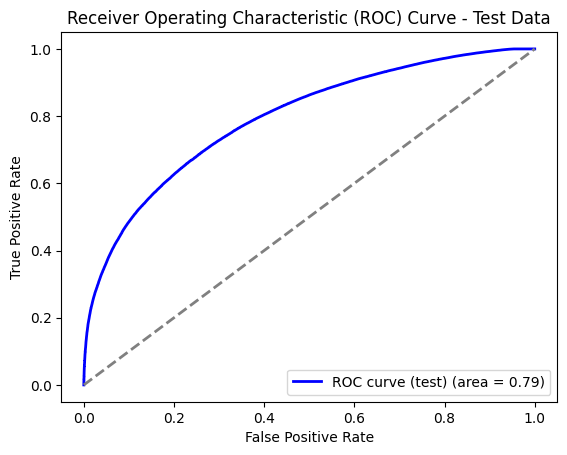

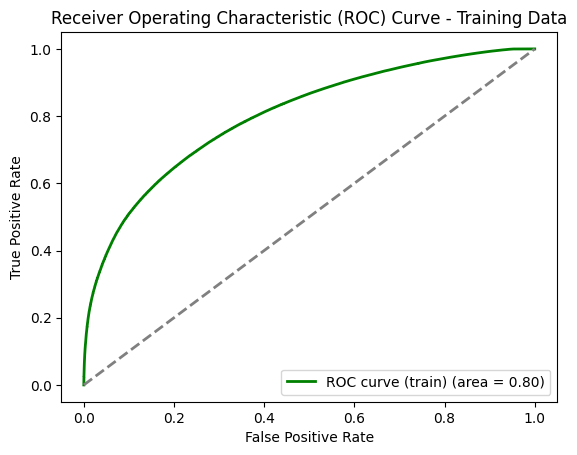

In [5]:
# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Test Accuracy: 0.738029893247905
Test Log Loss: 0.4080798524761573
Test ROC AUC: 0.8063319548873645
Test Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.68      0.66    111075
           1       0.81      0.77      0.79    189528

    accuracy                           0.74    300603
   macro avg       0.72      0.73      0.72    300603
weighted avg       0.74      0.74      0.74    300603

Class 0 Test Accuracy: 0.6824127841548503
Class 1 Test Accuracy: 0.7706249208560213
Train Accuracy: 0.7450785506061126
Train Log Loss: 0.5206549821353117
Train ROC AUC: 0.8417413402963325
Train Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.79      0.76    758110
           1       0.77      0.70      0.73    758110

    accuracy                           0.75   1516220
   macro avg       0.75      0.75      0.74   1516220
weighted avg       0.75      0.75      0.74   1516220

C

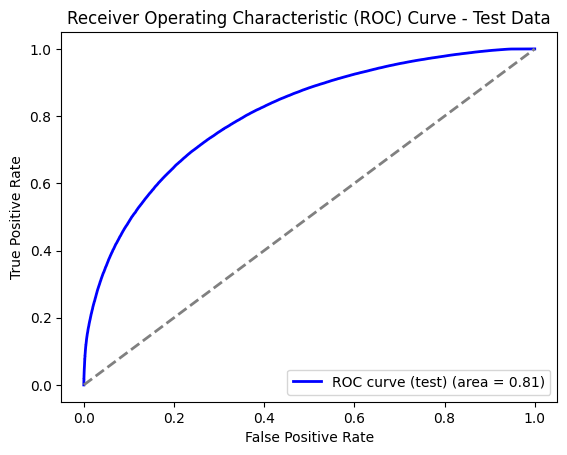

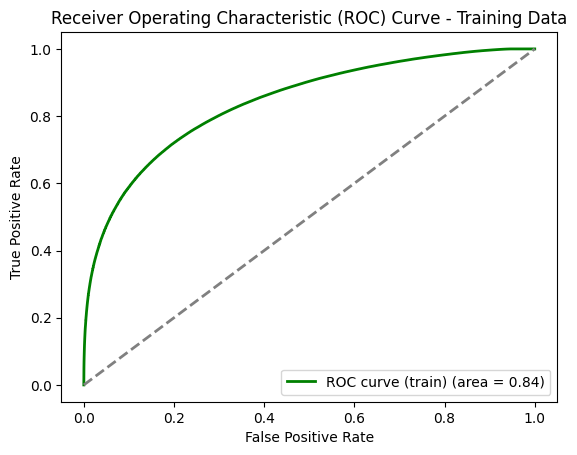

In [6]:
from catboost import CatBoostClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, classification_report, confusion_matrix, roc_curve

# Define the models
model_1 = CatBoostClassifier(
    depth=6,                      
    learning_rate=0.1,            
    iterations=100,               
    random_seed=42,               
    verbose=0                     
)

model_2 = CatBoostClassifier(
    depth=10,                    
    learning_rate=0.1,            
    iterations=500,               
    random_seed=42,               
    verbose=0                     
)

# Fit both models
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)

# Predict probabilities
proba_1 = model_1.predict_proba(X_test)
proba_2 = model_2.predict_proba(X_test)

y_train_pred_proba_1 = model_1.predict_proba(X_train)
y_train_pred_proba_2 = model_2.predict_proba(X_train)

# Custom combination logic
final_predictions = np.where(proba_1[:, 0] > proba_2[:, 1], 0, 1)
train_final_predictions = np.where(y_train_pred_proba_1[:, 0] > y_train_pred_proba_2[:, 1], 0, 1)

# Evaluate on test data
accuracy = accuracy_score(y_test, final_predictions)
log_loss_value = log_loss(y_test, np.column_stack((proba_1[:, 0], proba_2[:, 1])))
roc_auc = roc_auc_score(y_test, np.column_stack((proba_1[:, 0], proba_2[:, 1]))[:, 1])
report = classification_report(y_test, final_predictions)

# Evaluate on training data
train_accuracy = accuracy_score(y_train, train_final_predictions)
train_log_loss = log_loss(y_train, np.column_stack((y_train_pred_proba_1[:, 0], y_train_pred_proba_2[:, 1])))
train_roc_auc = roc_auc_score(y_train, np.column_stack((y_train_pred_proba_1[:, 0], y_train_pred_proba_2[:, 1]))[:, 1])
train_report = classification_report(y_train, train_final_predictions)

# Confusion matrices and class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, final_predictions)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

conf_matrix_train = confusion_matrix(y_train, train_final_predictions)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print results
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curves
fpr, tpr, _ = roc_curve(y_test, np.column_stack((proba_1[:, 0], proba_2[:, 1]))[:, 1])
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

fpr_train, tpr_train, _ = roc_curve(y_train, np.column_stack((y_train_pred_proba_1[:, 0], y_train_pred_proba_2[:, 1]))[:, 1])
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Test Accuracy: 0.7037820647165863
Test Log Loss: 0.4080798524761573
Test ROC AUC: 0.8063319548873645
Test Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.75      0.65    111075
           1       0.82      0.67      0.74    189528

    accuracy                           0.70    300603
   macro avg       0.70      0.71      0.70    300603
weighted avg       0.73      0.70      0.71    300603

Class 0 Test Accuracy: 0.753301823092505
Class 1 Test Accuracy: 0.6747604575577223
Train Accuracy: 0.7419609291527615
Train Log Loss: 0.5206549821353117
Train ROC AUC: 0.8417413402963325
Train Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.78      0.75    758110
           1       0.76      0.71      0.73    758110

    accuracy                           0.74   1516220
   macro avg       0.74      0.74      0.74   1516220
weighted avg       0.74      0.74      0.74   1516220

C

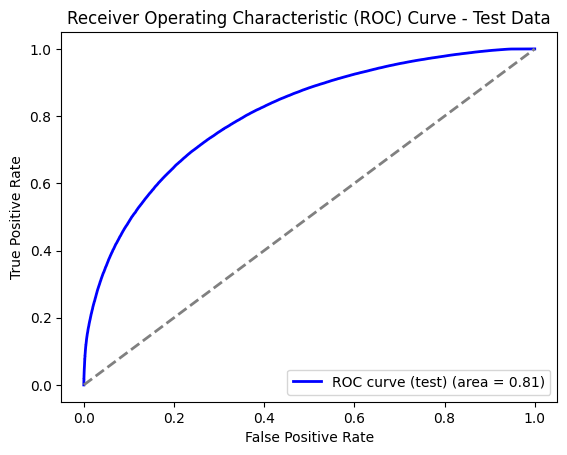

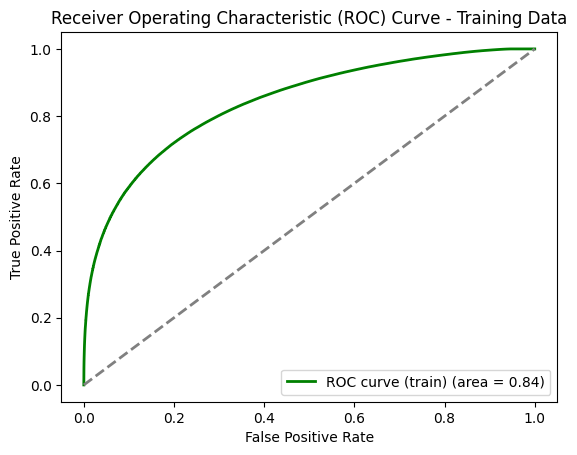

In [7]:
from catboost import CatBoostClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, classification_report, confusion_matrix, roc_curve

# Define the models
model_1 = CatBoostClassifier(
    depth=6, learning_rate=0.1, iterations=100, 
    random_seed=42, verbose=0)

model_2 = CatBoostClassifier(
    depth=10, learning_rate=0.1, iterations=500, 
    random_seed=42, verbose=0)

# Fit both models
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)

# Predict probabilities
proba_1 = model_1.predict_proba(X_test)
proba_2 = model_2.predict_proba(X_test)

y_train_pred_proba_1 = model_1.predict_proba(X_train)
y_train_pred_proba_2 = model_2.predict_proba(X_train)

# Adjust decision threshold to favor Class 0
threshold_0 = 0.55  # Increase bias towards Class 0
threshold_1 = 0.45  # Lower threshold for Class 1

final_predictions = np.where(proba_1[:, 0] > threshold_0, 0, 
                             np.where(proba_2[:, 1] > threshold_1, 1, 0))

train_final_predictions = np.where(y_train_pred_proba_1[:, 0] > threshold_0, 0, 
                                   np.where(y_train_pred_proba_2[:, 1] > threshold_1, 1, 0))

# Evaluate on test data
accuracy = accuracy_score(y_test, final_predictions)
log_loss_value = log_loss(y_test, np.column_stack((proba_1[:, 0], proba_2[:, 1])))
roc_auc = roc_auc_score(y_test, np.column_stack((proba_1[:, 0], proba_2[:, 1]))[:, 1])
report = classification_report(y_test, final_predictions)

# Evaluate on training data
train_accuracy = accuracy_score(y_train, train_final_predictions)
train_log_loss = log_loss(y_train, np.column_stack((y_train_pred_proba_1[:, 0], y_train_pred_proba_2[:, 1])))
train_roc_auc = roc_auc_score(y_train, np.column_stack((y_train_pred_proba_1[:, 0], y_train_pred_proba_2[:, 1]))[:, 1])
train_report = classification_report(y_train, train_final_predictions)

# Confusion matrices and class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, final_predictions)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

conf_matrix_train = confusion_matrix(y_train, train_final_predictions)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print results
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curves
fpr, tpr, _ = roc_curve(y_test, np.column_stack((proba_1[:, 0], proba_2[:, 1]))[:, 1])
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

fpr_train, tpr_train, _ = roc_curve(y_train, np.column_stack((y_train_pred_proba_1[:, 0], y_train_pred_proba_2[:, 1]))[:, 1])
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Test Accuracy: 0.7265396552928614
Test Log Loss: 0.4080798524761573
Test ROC AUC: 0.8063319548873645
Test Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.68      0.65    111075
           1       0.80      0.75      0.78    189528

    accuracy                           0.73    300603
   macro avg       0.71      0.72      0.71    300603
weighted avg       0.73      0.73      0.73    300603

Class 0 Test Accuracy: 0.6832410533423363
Class 1 Test Accuracy: 0.7519152842851716
Train Accuracy: 0.7489566157945416
Train Log Loss: 0.5206549821353117
Train ROC AUC: 0.8417413402963325
Train Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.76      0.75    758110
           1       0.75      0.74      0.75    758110

    accuracy                           0.75   1516220
   macro avg       0.75      0.75      0.75   1516220
weighted avg       0.75      0.75      0.75   1516220



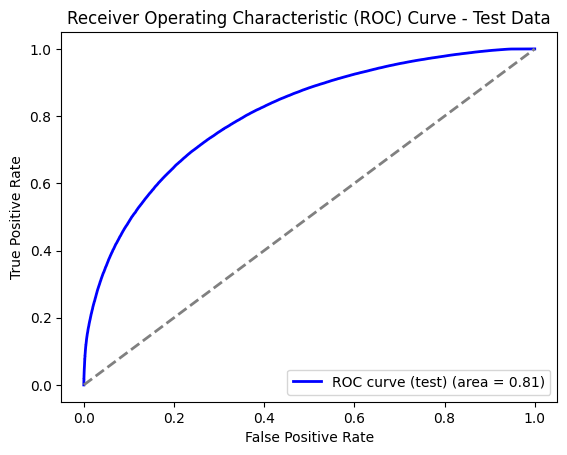

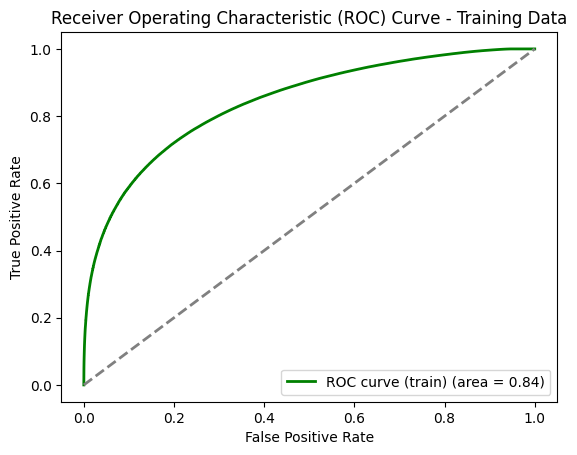

In [ ]:
from catboost import CatBoostClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, classification_report, confusion_matrix, roc_curve

# Define the models
model_1 = CatBoostClassifier(
    depth=6, learning_rate=0.1, iterations=100, 
    random_seed=42, verbose=0)

model_2 = CatBoostClassifier(
    depth=10, learning_rate=0.1, iterations=500, 
    random_seed=42, verbose=0)

# Fit both models
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)

# Predict probabilities
proba_1 = model_1.predict_proba(X_test)
proba_2 = model_2.predict_proba(X_test)

y_train_pred_proba_1 = model_1.predict_proba(X_train)
y_train_pred_proba_2 = model_2.predict_proba(X_train)

# Adjust decision threshold to favor Class 0
threshold_0 = 0.60  # Increase bias towards Class 0
threshold_1 = 0.45  # Lower threshold for Class 1

final_predictions = np.where(proba_1[:, 0] > threshold_0, 0, 
                             np.where(proba_2[:, 1] > threshold_1, 1, 0))

train_final_predictions = np.where(y_train_pred_proba_1[:, 0] > threshold_0, 0, 
                                   np.where(y_train_pred_proba_2[:, 1] > threshold_1, 1, 0))

# Evaluate on test data
accuracy = accuracy_score(y_test, final_predictions)
log_loss_value = log_loss(y_test, np.column_stack((proba_1[:, 0], proba_2[:, 1])))
roc_auc = roc_auc_score(y_test, np.column_stack((proba_1[:, 0], proba_2[:, 1]))[:, 1])
report = classification_report(y_test, final_predictions)

# Evaluate on training data
train_accuracy = accuracy_score(y_train, train_final_predictions)
train_log_loss = log_loss(y_train, np.column_stack((y_train_pred_proba_1[:, 0], y_train_pred_proba_2[:, 1])))
train_roc_auc = roc_auc_score(y_train, np.column_stack((y_train_pred_proba_1[:, 0], y_train_pred_proba_2[:, 1]))[:, 1])
train_report = classification_report(y_train, train_final_predictions)

# Confusion matrices and class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, final_predictions)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

conf_matrix_train = confusion_matrix(y_train, train_final_predictions)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print results
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curves
fpr, tpr, _ = roc_curve(y_test, np.column_stack((proba_1[:, 0], proba_2[:, 1]))[:, 1])
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

fpr_train, tpr_train, _ = roc_curve(y_train, np.column_stack((y_train_pred_proba_1[:, 0], y_train_pred_proba_2[:, 1]))[:, 1])
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Test Accuracy: 0.7375308962319072
Test Log Loss: 0.4080798524761573
Test ROC AUC: 0.8063319548873645
Test Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.66      0.65    111075
           1       0.80      0.79      0.79    189528

    accuracy                           0.74    300603
   macro avg       0.72      0.72      0.72    300603
weighted avg       0.74      0.74      0.74    300603

Class 0 Test Accuracy: 0.6558181408957912
Class 1 Test Accuracy: 0.7854195686125532
Train Accuracy: 0.7582191238738442
Train Log Loss: 0.5206549821353117
Train ROC AUC: 0.8417413402963325
Train Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.81      0.77    758110
           1       0.79      0.71      0.75    758110

    accuracy                           0.76   1516220
   macro avg       0.76      0.76      0.76   1516220
weighted avg       0.76      0.76      0.76   1516220



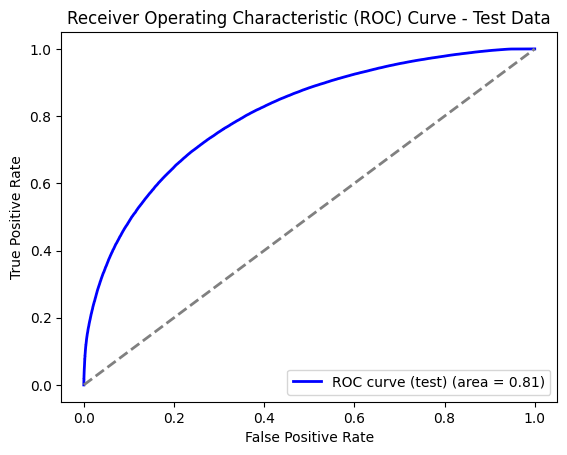

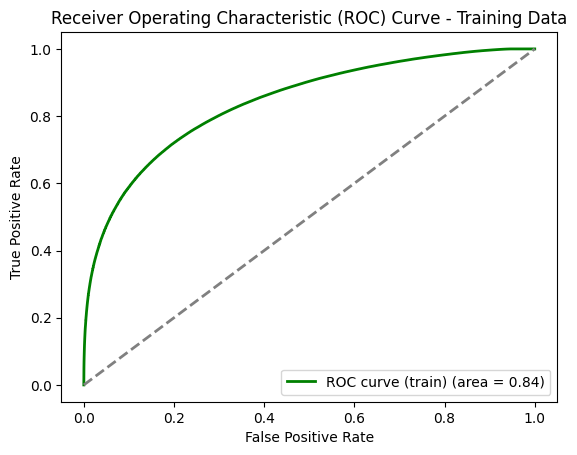

In [12]:
from catboost import CatBoostClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, classification_report, confusion_matrix, roc_curve

# Define the models
model_1 = CatBoostClassifier(
    depth=6, learning_rate=0.1, iterations=100, 
    random_seed=42, verbose=0)

model_2 = CatBoostClassifier(
    depth=10, learning_rate=0.1, iterations=500, 
    random_seed=42, verbose=0)

# Fit both models
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)

# Predict probabilities
proba_1 = model_1.predict_proba(X_test)
proba_2 = model_2.predict_proba(X_test)

y_train_pred_proba_1 = model_1.predict_proba(X_train)
y_train_pred_proba_2 = model_2.predict_proba(X_train)

# Adjust decision threshold to favor Class 0
threshold_0 = 0.65  # Increase bias towards Class 0
threshold_1 = 0.50  # Lower threshold for Class 1

final_predictions = np.where(proba_1[:, 0] > threshold_0, 0, 
                             np.where(proba_2[:, 1] > threshold_1, 1, 0))

train_final_predictions = np.where(y_train_pred_proba_1[:, 0] > threshold_0, 0, 
                                   np.where(y_train_pred_proba_2[:, 1] > threshold_1, 1, 0))

# Evaluate on test data
accuracy = accuracy_score(y_test, final_predictions)
log_loss_value = log_loss(y_test, np.column_stack((proba_1[:, 0], proba_2[:, 1])))
roc_auc = roc_auc_score(y_test, np.column_stack((proba_1[:, 0], proba_2[:, 1]))[:, 1])
report = classification_report(y_test, final_predictions)

# Evaluate on training data
train_accuracy = accuracy_score(y_train, train_final_predictions)
train_log_loss = log_loss(y_train, np.column_stack((y_train_pred_proba_1[:, 0], y_train_pred_proba_2[:, 1])))
train_roc_auc = roc_auc_score(y_train, np.column_stack((y_train_pred_proba_1[:, 0], y_train_pred_proba_2[:, 1]))[:, 1])
train_report = classification_report(y_train, train_final_predictions)

# Confusion matrices and class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, final_predictions)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

conf_matrix_train = confusion_matrix(y_train, train_final_predictions)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print results
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curves
fpr, tpr, _ = roc_curve(y_test, np.column_stack((proba_1[:, 0], proba_2[:, 1]))[:, 1])
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

fpr_train, tpr_train, _ = roc_curve(y_train, np.column_stack((y_train_pred_proba_1[:, 0], y_train_pred_proba_2[:, 1]))[:, 1])
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Test Accuracy: 0.6945472932738529
Test Log Loss: 0.5304652153276321
Test ROC AUC: 0.7961746545641136
Test Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.78      0.65    111075
           1       0.84      0.64      0.73    189528

    accuracy                           0.69    300603
   macro avg       0.70      0.71      0.69    300603
weighted avg       0.73      0.69      0.70    300603

Class 0 Test Accuracy: 0.7845599819941481
Class 1 Test Accuracy: 0.6417943522856782
Train Accuracy: 0.7216624236588358
Train Log Loss: 0.5422368338447758
Train ROC AUC: 0.803492492738236
Train Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.76      0.73    758110
           1       0.74      0.68      0.71    758110

    accuracy                           0.72   1516220
   macro avg       0.72      0.72      0.72   1516220
weighted avg       0.72      0.72      0.72   1516220

C

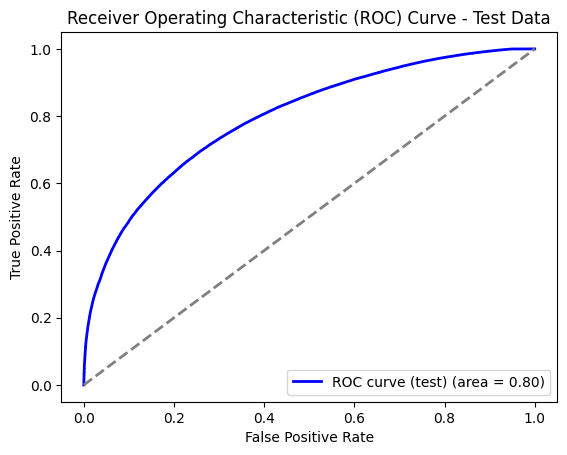

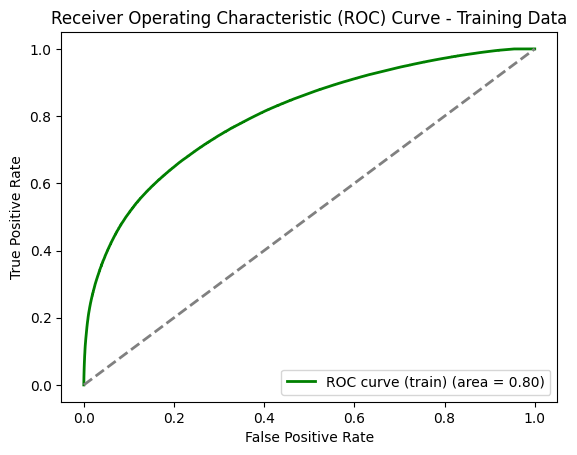

In [11]:
from catboost import CatBoostClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, classification_report, confusion_matrix, roc_curve

# Define the models
model_1 = CatBoostClassifier(
    depth=6,                      
    learning_rate=0.1,            
    iterations=100,               
    random_seed=42,               
    verbose=0                     
)

model_2 = xgb.XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=1.0,  # L2 regularization
    random_state=42
)

# Fit both models
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)

# Predict probabilities
proba_1 = model_1.predict_proba(X_test)
proba_2 = model_2.predict_proba(X_test)

y_train_pred_proba_1 = model_1.predict_proba(X_train)
y_train_pred_proba_2 = model_2.predict_proba(X_train)

# Custom combination logic
final_predictions = np.where(proba_1[:, 0] > proba_2[:, 1], 0, 1)
train_final_predictions = np.where(y_train_pred_proba_1[:, 0] > y_train_pred_proba_2[:, 1], 0, 1)

# Evaluate on test data
accuracy = accuracy_score(y_test, final_predictions)
log_loss_value = log_loss(y_test, np.column_stack((proba_1[:, 0], proba_2[:, 1])))
roc_auc = roc_auc_score(y_test, np.column_stack((proba_1[:, 0], proba_2[:, 1]))[:, 1])
report = classification_report(y_test, final_predictions)

# Evaluate on training data
train_accuracy = accuracy_score(y_train, train_final_predictions)
train_log_loss = log_loss(y_train, np.column_stack((y_train_pred_proba_1[:, 0], y_train_pred_proba_2[:, 1])))
train_roc_auc = roc_auc_score(y_train, np.column_stack((y_train_pred_proba_1[:, 0], y_train_pred_proba_2[:, 1]))[:, 1])
train_report = classification_report(y_train, train_final_predictions)

# Confusion matrices and class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, final_predictions)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

conf_matrix_train = confusion_matrix(y_train, train_final_predictions)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print results
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curves
fpr, tpr, _ = roc_curve(y_test, np.column_stack((proba_1[:, 0], proba_2[:, 1]))[:, 1])
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

fpr_train, tpr_train, _ = roc_curve(y_train, np.column_stack((y_train_pred_proba_1[:, 0], y_train_pred_proba_2[:, 1]))[:, 1])
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Test Accuracy: 0.6936391187047368
Test Log Loss: 0.5304652153276321
Test ROC AUC: 0.7961746545641136
Test Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.75      0.64    111075
           1       0.82      0.66      0.73    189528

    accuracy                           0.69    300603
   macro avg       0.69      0.71      0.69    300603
weighted avg       0.73      0.69      0.70    300603

Class 0 Test Accuracy: 0.7524555480531173
Class 1 Test Accuracy: 0.6591690937486809
Train Accuracy: 0.7194721082692486
Train Log Loss: 0.5422368338447758
Train ROC AUC: 0.803492492738236
Train Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.72      0.72    758110
           1       0.72      0.72      0.72    758110

    accuracy                           0.72   1516220
   macro avg       0.72      0.72      0.72   1516220
weighted avg       0.72      0.72      0.72   1516220

C

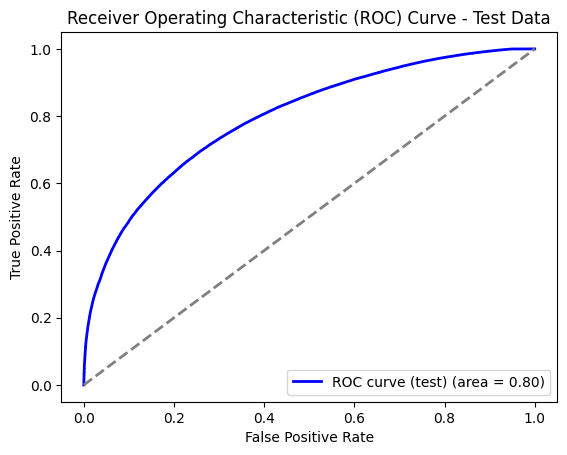

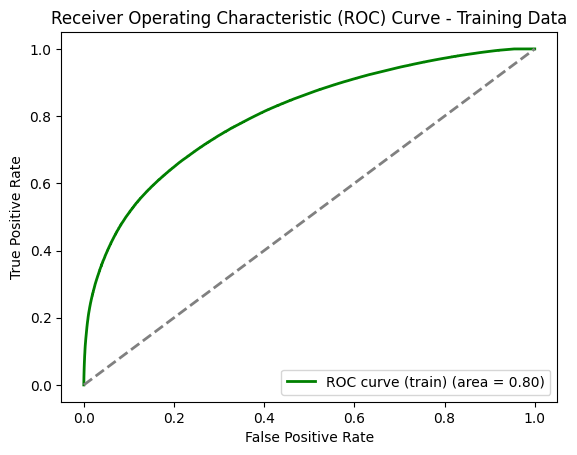

In [13]:
from catboost import CatBoostClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, classification_report, confusion_matrix, roc_curve

# Define the models
model_1 = CatBoostClassifier(
    depth=6,                      
    learning_rate=0.1,            
    iterations=100,               
    random_seed=42,               
    verbose=0                     
)

model_2 = xgb.XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=1.0,  # L2 regularization
    random_state=42
)


# Fit both models
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)

# Predict probabilities
proba_1 = model_1.predict_proba(X_test)
proba_2 = model_2.predict_proba(X_test)

y_train_pred_proba_1 = model_1.predict_proba(X_train)
y_train_pred_proba_2 = model_2.predict_proba(X_train)

# Adjust decision threshold to favor Class 0
threshold_0 = 0.55  # Increase bias towards Class 0
threshold_1 = 0.45  # Lower threshold for Class 1

final_predictions = np.where(proba_1[:, 0] > threshold_0, 0, 
                             np.where(proba_2[:, 1] > threshold_1, 1, 0))

train_final_predictions = np.where(y_train_pred_proba_1[:, 0] > threshold_0, 0, 
                                   np.where(y_train_pred_proba_2[:, 1] > threshold_1, 1, 0))

# Evaluate on test data
accuracy = accuracy_score(y_test, final_predictions)
log_loss_value = log_loss(y_test, np.column_stack((proba_1[:, 0], proba_2[:, 1])))
roc_auc = roc_auc_score(y_test, np.column_stack((proba_1[:, 0], proba_2[:, 1]))[:, 1])
report = classification_report(y_test, final_predictions)

# Evaluate on training data
train_accuracy = accuracy_score(y_train, train_final_predictions)
train_log_loss = log_loss(y_train, np.column_stack((y_train_pred_proba_1[:, 0], y_train_pred_proba_2[:, 1])))
train_roc_auc = roc_auc_score(y_train, np.column_stack((y_train_pred_proba_1[:, 0], y_train_pred_proba_2[:, 1]))[:, 1])
train_report = classification_report(y_train, train_final_predictions)

# Confusion matrices and class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, final_predictions)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

conf_matrix_train = confusion_matrix(y_train, train_final_predictions)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print results
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curves
fpr, tpr, _ = roc_curve(y_test, np.column_stack((proba_1[:, 0], proba_2[:, 1]))[:, 1])
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

fpr_train, tpr_train, _ = roc_curve(y_train, np.column_stack((y_train_pred_proba_1[:, 0], y_train_pred_proba_2[:, 1]))[:, 1])
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Test Accuracy: 0.6717331497024315
Test Log Loss: 0.443509049273694
Test ROC AUC: 0.794061491735162
Test Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.81      0.65    111075
           1       0.84      0.59      0.69    189528

    accuracy                           0.67    300603
   macro avg       0.69      0.70      0.67    300603
weighted avg       0.73      0.67      0.68    300603

Class 0 Test Accuracy: 0.8107224848075625
Class 1 Test Accuracy: 0.5902768984002363
Train Accuracy: 0.7156144886625951
Train Log Loss: 0.4757547418700412
Train ROC AUC: 0.8032372092870577
Train Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.76      0.73    758110
           1       0.74      0.67      0.70    758110

    accuracy                           0.72   1516220
   macro avg       0.72      0.72      0.72   1516220
weighted avg       0.72      0.72      0.72   1516220

Cl

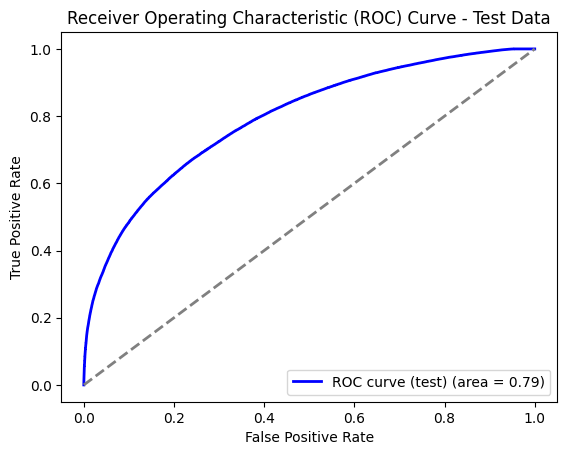

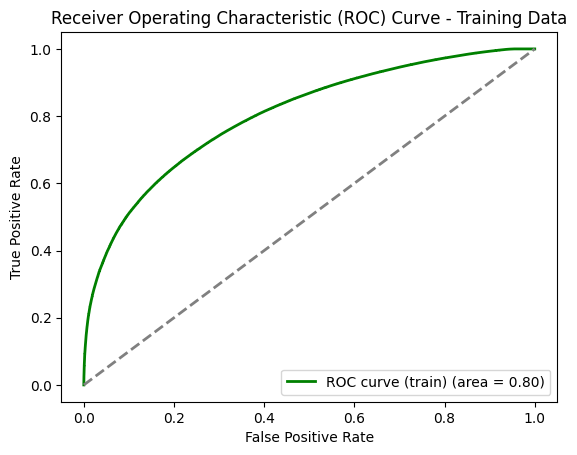

In [14]:
from catboost import CatBoostClassifier
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, classification_report, confusion_matrix, roc_curve

# Define the models
model_1 = CatBoostClassifier(
    depth=6, learning_rate=0.1, iterations=100, 
    random_seed=42, verbose=0)

model_2 = xgb.XGBClassifier(
    max_depth=6, learning_rate=0.1, n_estimators=100, 
    subsample=0.8, colsample_bytree=0.8, 
    reg_alpha=0.1, reg_lambda=1.0, 
    scale_pos_weight=1.5,  # Increase weight for Class 0
    random_state=42)

# Fit both models
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)

# Predict probabilities
proba_1 = model_1.predict_proba(X_test)
proba_2 = model_2.predict_proba(X_test)

y_train_pred_proba_1 = model_1.predict_proba(X_train)
y_train_pred_proba_2 = model_2.predict_proba(X_train)

# Adjust decision threshold to favor Class 0
threshold_0 = 0.6  # Increase bias towards Class 0
threshold_1 = 0.4  # Lower threshold for Class 1

final_predictions = np.where(proba_1[:, 0] * 1.2 > threshold_0, 0, 
                             np.where(proba_2[:, 1] > threshold_1, 1, 0))

train_final_predictions = np.where(y_train_pred_proba_1[:, 0] * 1.2 > threshold_0, 0, 
                                   np.where(y_train_pred_proba_2[:, 1] > threshold_1, 1, 0))

# Evaluate on test data
accuracy = accuracy_score(y_test, final_predictions)
log_loss_value = log_loss(y_test, np.column_stack((proba_1[:, 0], proba_2[:, 1])))
roc_auc = roc_auc_score(y_test, np.column_stack((proba_1[:, 0], proba_2[:, 1]))[:, 1])
report = classification_report(y_test, final_predictions)

# Evaluate on training data
train_accuracy = accuracy_score(y_train, train_final_predictions)
train_log_loss = log_loss(y_train, np.column_stack((y_train_pred_proba_1[:, 0], y_train_pred_proba_2[:, 1])))
train_roc_auc = roc_auc_score(y_train, np.column_stack((y_train_pred_proba_1[:, 0], y_train_pred_proba_2[:, 1]))[:, 1])
train_report = classification_report(y_train, train_final_predictions)

# Confusion matrices and class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, final_predictions)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

conf_matrix_train = confusion_matrix(y_train, train_final_predictions)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print results
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curves
fpr, tpr, _ = roc_curve(y_test, np.column_stack((proba_1[:, 0], proba_2[:, 1]))[:, 1])
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

fpr_train, tpr_train, _ = roc_curve(y_train, np.column_stack((y_train_pred_proba_1[:, 0], y_train_pred_proba_2[:, 1]))[:, 1])
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Test Accuracy: 0.6678243397437816
Test Log Loss: 0.4940630365448561
Test ROC AUC: 0.7905661171589009
Test Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.81      0.64    111075
           1       0.84      0.58      0.69    189528

    accuracy                           0.67    300603
   macro avg       0.69      0.70      0.67    300603
weighted avg       0.73      0.67      0.67    300603

Class 0 Test Accuracy: 0.81407157326131
Class 1 Test Accuracy: 0.5821145160609514
Train Accuracy: 0.7161731147194998
Train Log Loss: 0.5107313205772281
Train ROC AUC: 0.8035521800321225
Train Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.76      0.73    758110
           1       0.74      0.67      0.70    758110

    accuracy                           0.72   1516220
   macro avg       0.72      0.72      0.72   1516220
weighted avg       0.72      0.72      0.72   1516220

Cl

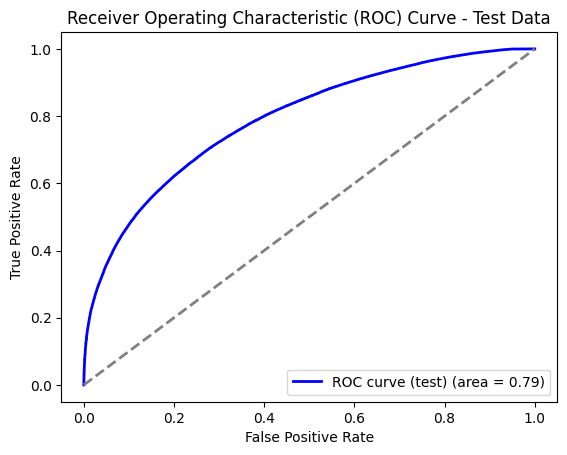

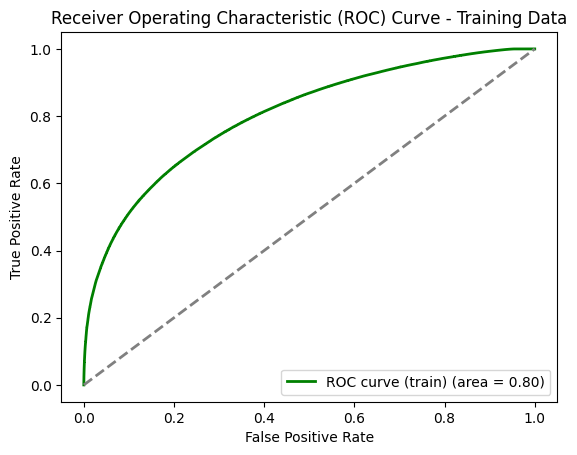

In [15]:
from catboost import CatBoostClassifier
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, classification_report, confusion_matrix, roc_curve

# Define the models
model_1 = CatBoostClassifier(
    depth=6, learning_rate=0.1, iterations=100, 
    random_seed=42, verbose=0)

model_2 = xgb.XGBClassifier(
    max_depth=6, learning_rate=0.1, n_estimators=100, 
    subsample=0.8, colsample_bytree=0.8, 
    reg_alpha=0.1, reg_lambda=1.0, 
    scale_pos_weight=1.2,  # Adjust weight for Class 1 improvement
    random_state=42)

# Fit both models
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)

# Predict probabilities
proba_1 = model_1.predict_proba(X_test)
proba_2 = model_2.predict_proba(X_test)

y_train_pred_proba_1 = model_1.predict_proba(X_train)
y_train_pred_proba_2 = model_2.predict_proba(X_train)

# Adjust decision threshold to balance Class 1 accuracy
threshold_0 = 0.6  # Keep bias towards Class 0
threshold_1 = 0.5  # Increase threshold for Class 1

final_predictions = np.where(proba_1[:, 0] * 1.2 > threshold_0, 0, 
                             np.where(proba_2[:, 1] * 1.1 > threshold_1, 1, 0))

train_final_predictions = np.where(y_train_pred_proba_1[:, 0] * 1.2 > threshold_0, 0, 
                                   np.where(y_train_pred_proba_2[:, 1] * 1.1 > threshold_1, 1, 0))

# Evaluate on test data
accuracy = accuracy_score(y_test, final_predictions)
log_loss_value = log_loss(y_test, np.column_stack((proba_1[:, 0], proba_2[:, 1])))
roc_auc = roc_auc_score(y_test, np.column_stack((proba_1[:, 0], proba_2[:, 1]))[:, 1])
report = classification_report(y_test, final_predictions)

# Evaluate on training data
train_accuracy = accuracy_score(y_train, train_final_predictions)
train_log_loss = log_loss(y_train, np.column_stack((y_train_pred_proba_1[:, 0], y_train_pred_proba_2[:, 1])))
train_roc_auc = roc_auc_score(y_train, np.column_stack((y_train_pred_proba_1[:, 0], y_train_pred_proba_2[:, 1]))[:, 1])
train_report = classification_report(y_train, train_final_predictions)

# Confusion matrices and class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, final_predictions)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

conf_matrix_train = confusion_matrix(y_train, train_final_predictions)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print results
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curves
fpr, tpr, _ = roc_curve(y_test, np.column_stack((proba_1[:, 0], proba_2[:, 1]))[:, 1])
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

fpr_train, tpr_train, _ = roc_curve(y_train, np.column_stack((y_train_pred_proba_1[:, 0], y_train_pred_proba_2[:, 1]))[:, 1])
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Test Accuracy: 0.7256481139576119
Test Log Loss: 0.4080798524761573
Test ROC AUC: 0.8063319548873645
Test Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.71      0.66    111075
           1       0.81      0.74      0.77    189528

    accuracy                           0.73    300603
   macro avg       0.71      0.72      0.71    300603
weighted avg       0.74      0.73      0.73    300603

Class 0 Test Accuracy: 0.7087283367094306
Class 1 Test Accuracy: 0.7355641382803596
Train Accuracy: 0.7546207014813153
Train Log Loss: 0.5206549821353117
Train ROC AUC: 0.8417413402963325
Train Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.81      0.77    758110
           1       0.79      0.70      0.74    758110

    accuracy                           0.75   1516220
   macro avg       0.76      0.75      0.75   1516220
weighted avg       0.76      0.75      0.75   1516220



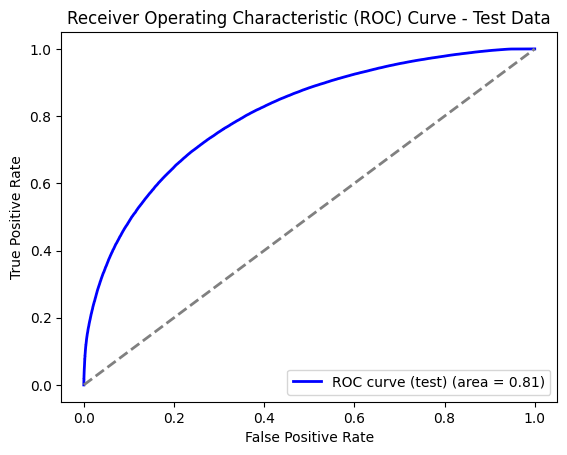

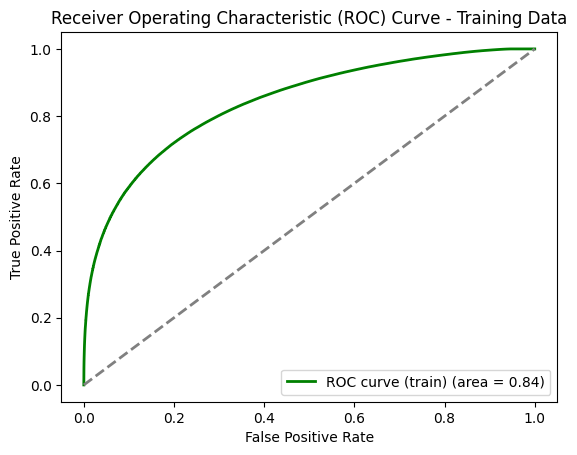

In [16]:
from catboost import CatBoostClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, classification_report, confusion_matrix, roc_curve

# Define the models
model_1 = CatBoostClassifier(
    depth=6, learning_rate=0.1, iterations=100, 
    random_seed=42, verbose=0)

model_2 = CatBoostClassifier(
    depth=10, learning_rate=0.1, iterations=500, 
    random_seed=42, verbose=0)

# Fit both models
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)

# Predict probabilities
proba_1 = model_1.predict_proba(X_test)
proba_2 = model_2.predict_proba(X_test)

y_train_pred_proba_1 = model_1.predict_proba(X_train)
y_train_pred_proba_2 = model_2.predict_proba(X_train)

# Adjust decision threshold to favor Class 0
threshold_0 = 0.60  # Increase bias towards Class 0
threshold_1 = 0.50  # Lower threshold for Class 1

final_predictions = np.where(proba_1[:, 0] > threshold_0, 0, 
                             np.where(proba_2[:, 1] > threshold_1, 1, 0))

train_final_predictions = np.where(y_train_pred_proba_1[:, 0] > threshold_0, 0, 
                                   np.where(y_train_pred_proba_2[:, 1] > threshold_1, 1, 0))

# Evaluate on test data
accuracy = accuracy_score(y_test, final_predictions)
log_loss_value = log_loss(y_test, np.column_stack((proba_1[:, 0], proba_2[:, 1])))
roc_auc = roc_auc_score(y_test, np.column_stack((proba_1[:, 0], proba_2[:, 1]))[:, 1])
report = classification_report(y_test, final_predictions)

# Evaluate on training data
train_accuracy = accuracy_score(y_train, train_final_predictions)
train_log_loss = log_loss(y_train, np.column_stack((y_train_pred_proba_1[:, 0], y_train_pred_proba_2[:, 1])))
train_roc_auc = roc_auc_score(y_train, np.column_stack((y_train_pred_proba_1[:, 0], y_train_pred_proba_2[:, 1]))[:, 1])
train_report = classification_report(y_train, train_final_predictions)

# Confusion matrices and class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, final_predictions)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

conf_matrix_train = confusion_matrix(y_train, train_final_predictions)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print results
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curves
fpr, tpr, _ = roc_curve(y_test, np.column_stack((proba_1[:, 0], proba_2[:, 1]))[:, 1])
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

fpr_train, tpr_train, _ = roc_curve(y_train, np.column_stack((y_train_pred_proba_1[:, 0], y_train_pred_proba_2[:, 1]))[:, 1])
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.7256481139576119
Test Log Loss: 0.6831869102821315
Test ROC AUC: 0.6547183006852814
Test Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.71      0.66    111075
           1       0.81      0.74      0.77    189528

    accuracy                           0.73    300603
   macro avg       0.71      0.72      0.71    300603
weighted avg       0.74      0.73      0.73    300603

Class 0 Test Accuracy: 0.7087283367094306
Class 1 Test Accuracy: 0.7355641382803596
Train Accuracy: 0.7546207014813153
Train Log Loss: 0.7832333946836211
Train ROC AUC: 0.6288187303212956
Train Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.81      0.77    758110
           1       0.79      0.70      0.74    758110

    accuracy                           0.75   1516220
   macro avg       0.76      0.75      0.75   1516220
weighted avg       0.76      0.75      0.75   1516220



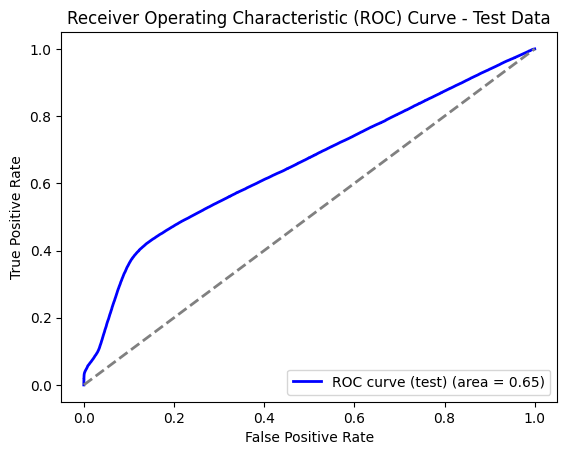

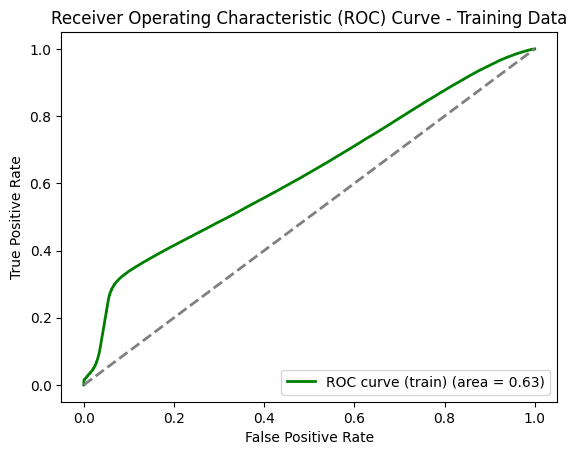

In [17]:
from catboost import CatBoostClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, classification_report, confusion_matrix, roc_curve

# Define the models
model_1 = CatBoostClassifier(
    depth=6, learning_rate=0.1, iterations=100, 
    random_seed=42, verbose=0)

model_2 = CatBoostClassifier(
    depth=10, learning_rate=0.1, iterations=500, 
    random_seed=42, verbose=0)

# Fit both models
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)

# Predict probabilities
proba_1 = model_1.predict_proba(X_test)
proba_2 = model_2.predict_proba(X_test)

y_train_pred_proba_1 = model_1.predict_proba(X_train)
y_train_pred_proba_2 = model_2.predict_proba(X_train)

# Adjust decision threshold to favor Class 0
threshold_0 = 0.60  # Increase bias towards Class 0
threshold_1 = 0.50  # Lower threshold for Class 1

# Predict class labels
final_predictions = np.where(proba_1[:, 0] > threshold_0, 0, 
                             np.where(proba_2[:, 1] > threshold_1, 1, 0))

train_final_predictions = np.where(y_train_pred_proba_1[:, 0] > threshold_0, 0, 
                                   np.where(y_train_pred_proba_2[:, 1] > threshold_1, 1, 0))

# Predict probability scores (taking the maximum confidence)
final_prediction_proba = np.maximum(proba_1[:, 0], proba_2[:, 1])
train_final_prediction_proba = np.maximum(y_train_pred_proba_1[:, 0], y_train_pred_proba_2[:, 1])

# Evaluate on test data
accuracy = accuracy_score(y_test, final_predictions)
log_loss_value = log_loss(y_test, final_prediction_proba)  # Use correct probabilities
roc_auc = roc_auc_score(y_test, final_prediction_proba)  # Use correct probabilities
report = classification_report(y_test, final_predictions)

# Evaluate on training data
train_accuracy = accuracy_score(y_train, train_final_predictions)
train_log_loss = log_loss(y_train, train_final_prediction_proba)  # Use correct probabilities
train_roc_auc = roc_auc_score(y_train, train_final_prediction_proba)  # Use correct probabilities
train_report = classification_report(y_train, train_final_predictions)

# Confusion matrices and class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, final_predictions)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

conf_matrix_train = confusion_matrix(y_train, train_final_predictions)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print results
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curves
fpr, tpr, _ = roc_curve(y_test, final_prediction_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

fpr_train, tpr_train, _ = roc_curve(y_train, train_final_prediction_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()
